### Load packages and variables

Use the  conda env ID_CRE_env with the following pip installs:  
pip install nb_black

In [1]:
from gimmemotifs.preprocessing import combine_peaks
from gimmemotifs.preprocessing import coverage_table
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import subprocess as sp
import qnorm  # either add qnorm to the yml, or run conda install qnorm in the env
import gseapy as gp
from gseapy.plot import barplot, dotplot
import itertools

os.chdir("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/scripts")
from Python_scripts import bedtool_closest
from Python_scripts import coverage_table_normalization
from Python_scripts import genome_TSS_annotation
from Python_scripts import genome_TSS_annotation_prom
from Python_scripts import make_autopct
from Python_scripts import summits_2_regions
from Python_scripts import distance_weight

plt.style.use("classic")
%matplotlib inline
%load_ext nb_black
%reload_ext nb_black
os.chdir("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/tools/scripts")
from Python_scripts import TSS_to_region

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
class analysis:
    """contains all the first steps of my general analysis, including reading a filepath file, config file, and
    exporting those and the conda environment to a logdir.
    required input:
    datapaths_file, a tsv file containing all the other filepaths needed in the subsequent analysis
    config_file, a tsv file containing all type of settings and paramters
    output_dir, where to store the output generated by the analysis, it will generate 
    a log and figure dir in this ouput dir
    """

    def __init__(self, datapaths_file: str, config_file: str, output_dir: str, notebook_file: str):
        self.datapaths_file = datapaths_file
        self.config_file = config_file
        self.output_dir = output_dir
        self.files = pd.read_table(
            self.datapaths_file, sep="\t", comment="#", index_col=0, header = 0
        )
        self.config = pd.read_table(
            self.config_file, sep="\t", comment="#", index_col=0, header = 0
        )
        self.notebook_file = notebook_file
        self.logdir = f"{self.output_dir}/logs"
        self.figdir = f"{self.output_dir}/figures"
        self.trackhubdir = f"{self.output_dir}/trackhub"
        self.tmpdir = f"{self.output_dir}/tmp"
        Path(self.tmpdir).mkdir(parents=True, exist_ok=True)
        Path(self.logdir).mkdir(parents=True, exist_ok=True)
        Path(self.figdir).mkdir(parents=True, exist_ok=True)
        Path(self.trackhubdir).mkdir(parents=True, exist_ok=True)


    def save_settings(self, conda_path):
        """save the config and files to the logs, and make a copy of the conda env that his analysis
        is ran in. Takes a full path to the conda env location as input"""
        #save the conda environment
        !{conda_path} list > {self.logdir}/conda_env.txt
        # save both the files and settings of this run to the output_dir
        self.files.T.to_csv(f"{self.logdir}/filepaths.tsv", header=False, sep="\t")
        self.config.to_csv(f"{self.logdir}/config.tsv", header=False, sep="\t")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
class general_bedfile_functions:
    """general functions for working with bedfiles & Chromosome coordinates"""

    def filter_bedfile(
        self,
        list_chroms_to_remove: list,
        output_name: str = None,
        bedfile: str = None,
        bed_object: str = None,
        filter_column: str = "Chrom",
        file_output=False,
        return_output=False,
    ):
        """takes a bedfile with x columns and filter to remove a specific list of strings from a column
        if there is no string given, it will try to use the class object df bed.df instead"""
        if bedfile == None:
            bed_df = self.bed_df
        else:
            bed_df = pd.read_table(bedfile, header=None)

        bed_df = bed_df[
            ~bed_df[filter_column].str.contains("|".join(list_chroms_to_remove))
        ]
        if file_output == True:
            bed_df.to_csv(
                f"{self.output_dir}/{output_name}.bed",
                sep="\t",
                header=False,
                index=False,
            )
        if return_output == True:
            return bed_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
class identify_prom_windows(analysis, general_bedfile_functions):
    """identify TSS based promoter windows
    """

    def __init__(self, *args, **kwargs):
        analysis.__init__(self,*args, **kwargs)

    def filter_gtf_file(
        self,
        gtf_file_name: str = "genome_gtf",
        filter_column: int = 17,
        regex: [str] = '";protein_coding"',
        skip_lines: int = 5,
        rerun: bool = False,
    ):
        """filter a (ensembl) gtf file for only containing data of specific transcripts (e.g. genes)
        name of the gtf file in the filepath file
        column to use for filtering (default 17, for ensembl protein coding)
        regex: regex string to keep.
        skip lines: skip the first x lines for skipping meta data of a gtf file
        rerun: rerun if file already excists
        """
        # first check if the filtered gtf file already exists
        self.filtered_gtf = f"{self.tmpdir}/filtered_annotation.gtf"
        if not os.path.exists(self.filtered_gtf) or rerun == True:
            print("filtering GTF_file")
            gtf_file = self.files.loc[gtf_file_name, :].file_location
            Path(f"{self.filtered_gtf}").touch()
            os.remove(f"{self.filtered_gtf}")
            with open(f"{self.filtered_gtf}", "a") as output_gtf:
                with open(gtf_file) as f:
                    for _ in range(skip_lines):
                        next(f)
                    for full_line in f:
                        line = full_line.strip()
                        line = line.split()
                        if str(line[filter_column]) == regex:
                            output_gtf.write(full_line)
        else:
            print('reusing previously filtered gtf file')
        

    def make_TSS_window(
        self,
        TSS_file: str,
        sense_antisense_column: int = 6,
        gene_name_column: int = 13,
        chrom_columnn: int = 0,
        chromstart_columnn: int = 3,
        chromend_columnn: int = 4,
        region_upstream: int = 2000,
        region_downstream: int = 2000,
        rerun=False,
    ):
        """
        Takes a genome gtf TSS file as input, with column info regarding sense/antisense, chr, chrstart, chrend, and
        finally how far up or downstream the window needs to be elongated.
        and returns a smaller gtf file containing only the coordinates of the specified TSS region and the gene name.
        """
        # first check if the filtered gtf file already exists
        print("windowing TSS file")
        tempfile = f"{self.output_dir}/temp_TSS_window.txt"
        Path(tempfile).touch()
        os.remove(f"{tempfile}")

        with open(f"{tempfile}", "a") as output_gtf:
            with open(TSS_file) as f:
                for line in f:
                    line = line.strip()
                    line = line.split()
                    # calculate the adjusted start and stop coordinates, if smaller than 0, make it 1
                    if line[sense_antisense_column] == "+":
                        chromstart = int(line[chromstart_columnn]) - int(
                            region_upstream
                        )
                        if chromstart <= 0:
                            chromstart = 1
                        chromend = (int(line[chromstart_columnn]) + 1) + int(
                            region_downstream
                        )
                    elif line[sense_antisense_column] == "-":
                        chromstart = int(line[chromend_columnn]) - int(
                            region_downstream
                        )
                        if chromstart <= 0:
                            chromstart = 1
                        chromend = (
                            int(line[chromend_columnn]) - 1 + int(region_upstream)
                        )
                        chromstart_temp = chromstart
                        chromstart = chromend
                        chromend = chromstart_temp
                        

                    output_gtf.write(
                        str(line[chrom_columnn])
                        + "\t"
                        + str(chromstart)
                        + "\t"
                        + str(chromend)
                        + "\t"
                        + str(line[sense_antisense_column])
                        + "\t"
                        + str(line[gene_name_column].rstrip(";"))
                        + "\n"
                    )
        tempfilesorted = f"{self.output_dir}/temp_TSS_window_s.txt"
        Path(tempfilesorted).touch()
        os.remove(f"{tempfilesorted}")

        if region_upstream == 0 & region_downstream == 0:
            self.bed_df = pd.read_table(tempfile, header=None, names = ['Chrom','ChromStart','ChromEnd','strand','gene'])
        else:
            sp.check_call(
                f"nice -5 bedtools sort " f"-i {tempfile} " f"> {tempfilesorted}",
                shell=True,
                
            )
            self.bed_df = pd.read_table(tempfilesorted, header=None, names = ['Chrom','ChromStart','ChromEnd','strand','gene'])
            os.remove(tempfilesorted)
        os.remove(tempfile)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
class Identify_differential_CREs(identify_prom_windows):
    """Identify variable CRE elements in my analysis"""

    def __init__(self, *args, **kwargs):
        analysis.__init__(self, *args, **kwargs)

    def quantify_histon_mod(
        self,
        regions,
        bamfiles,
        output_file=None,
        alter_window=False,
        extend_start=0,
        extend_end=0,
        rerun=False,
        colnames="bamfiles",
        coverage_window=200,
    ):
        """quantify the ammount of signal in regions in a bedfile/bedobject within a list of bamfiles.
        Optionally you can modify the chromstart and chromend coordinates of the bedfile using alter_window
        and giving a extend_start and extend end number in bp"""
        print("doing stuff")
        if rerun == True or ((output_file != None) & (not os.path.exists(output_file))):
            print("quantifying histone mod")
            if alter_window == True:
                print("resize regions")
                regions["ChromStart"] = regions["ChromStart"].astype(int) - extend_start
                regions["ChromEnd"] = regions["ChromEnd"].astype(int) + extend_end

            regions.to_csv(
                f"{self.tmpdir}/window_regions_quantwindow.bed",
                sep="\t",
                header=False,
                index=False,
            )

            reads_table = coverage_table(
                peakfile=f"{self.tmpdir}/window_regions_quantwindow.bed",
                datafiles=bamfiles,
                window=int(coverage_window),
                log_transform=False,
                ncpus=int(self.config.loc["ncores", :].vallue),
            )
            

            if colnames != "bamfiles":
                print("replacing column names")
                reads_table.columns = colnames
                
            reads_table = reads_table.drop_duplicates()
            reads_table = reads_table.astype(int)
            reads_table.insert(loc=0, column='region', value=reads_table.index)

            if output_file != None:
                reads_table.to_csv(
                    f"{output_file}",
                    sep="\t",
                    header=True,
                    index=False,
                )
            return reads_table
        
        if rerun == False and ((output_file != None) & (os.path.exists(output_file))):
            print('using previously generated table')
            reads_table = pd.read_table(f"{output_file}",sep="\t",index_col = 0)        
            return reads_table



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Lets save all the parameters and code from the analysis:

In [6]:
ID_CREs = Identify_differential_CREs(
    datapaths_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/files.tsv",
    config_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/config.tsv",
    output_dir="/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/2021-28-07",
    notebook_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/ID_CREs_OOP.ipynb",
)

ID_CREs.main_dir = (
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs"
)
ID_CREs.save_settings("/vol/mbconda/jsmits/condabin/conda")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
ID_CREs.filter_gtf_file(
    filter_column=17,
    regex='"protein_coding";',
    skip_lines=5,
    rerun=False,
)

reusing previously filtered gtf file


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

next we will select two different types of promoter regions, 2000kb upstream of the TSS, or a 20kb window.
we will filter the regions to remove alternative patches and sex chromosomes:

In [8]:
ID_CREs.make_TSS_window(
    TSS_file=f"{ID_CREs.tmpdir}/filtered_annotation.gtf",
    region_upstream=0,
    region_downstream=0,
    rerun=True,
)
ID_CREs.filter_bedfile(
    ["GL", "Un", "KI", "MT", "X", "Y"], file_output=True, output_name="/TSS_1bp"
)
ID_CREs.TSS_1bp = ID_CREs.filter_bedfile(
    ["GL", "Un", "KI", "MT", "X", "Y"], return_output=True
)
ID_CREs.TSS_1bp

windowing TSS file


,Chrom,ChromStart,ChromEnd,strand,gene
0,1,65419,65420,+,OR4F5
1,1,451696,451697,-,OR4F29
2,1,686672,686673,-,OR4F16
3,1,923928,923929,+,SAMD11
4,1,959308,959309,-,NOC2L
...,...,...,...,...,...
19919,21,46324141,46324142,+,PCNT
19920,21,46326288,46326289,+,AP000471.1
19921,21,46458891,46458892,+,DIP2A
19922,21,46605207,46605208,-,S100B


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finally we will output a list of all genes located on chrom1 for the model testing

In [9]:
ID_CREs.TSS_1bp[ID_CREs.TSS_1bp["Chrom"] == "1"]["gene"].to_csv(
    f"{ID_CREs.output_dir}/chrom1genes.txt",
    sep="\t",
    header=False,
    index=False,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ATAC seq summits, the second type of regions.

We will next try to identify the most relevant binding regions using ATACseq peak data.
Since there is a different ammount of seq depth per cell type, we will first merge the ATAC peaks within each cell type. After doing this, we will take an equal ammount of peaks from each cell type. Taking the most accesible peaks to try to aleviate potential seqdepth bias.

Finally, after selecting the top 100.000 peaks in each cell type, we will combine all the LSC and KC signal, 


###WIP next aproach, merge all the peaks, quantify the relative abundance of each peak in each cell type. Take the top 100.000 peaks of each cell type to continue with. Result = no overlap and minimum seq depth bias.

In [10]:
### Final peakmerge approach
merged_summits = list()

if not os.path.exists(f"{ID_CREs.output_dir}/accesible_summits.bed"):
    ATAC_peaks = ID_CREs.files[ID_CREs.files.data_type == "ATAC_peak"]
    ATAC_pfiles = ATAC_peaks.file_location
    ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
    ATAC_BAM = ATAC_BAM.file_location
    combined_ATAC_peaks = combine_peaks(
        list(ATAC_pfiles),
        ID_CREs.files.loc["genome_path_size", :].file_location,
        ID_CREs.config.loc["ATAC_summit", :].vallue,
        True,
    )
    combined_ATAC_peaks.to_csv(
        f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks.bed",
        sep="\t",
        header=False,
        index=False,
    )

    # quantify the peak intensity per cell type
    cell_types = np.unique(
        ID_CREs.files[ID_CREs.files.data_type == "ATAC_peak"].cell_type,
        return_index=False,
    )

    for cell in cell_types:
        print(cell)
        ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
        ATAC_BAM = ATAC_BAM[ATAC_BAM.cell_type == cell].file_location

        print("rerunning coverage table top 100.000 ATAC peaks")
        peak_counts = coverage_table(
            peakfile=f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks.bed",
            datafiles=list(ATAC_BAM),
            window=int(ID_CREs.config.loc["ATAC_summit", :][0]),
            log_transform=False,
            ncpus=int(ID_CREs.config.loc["ncores", :][0]),
        )
        peak_counts = peak_counts[
            ~peak_counts.index.str.contains(
                "|".join(["GL", "Un", "KI", "MT", "X", "Y"])
            )
        ]
        peak_counts["total_counts"] = peak_counts.sum(axis=1)
        top_peaks = peak_counts.sort_values(by=["total_counts"], ascending=False).head(
            100000
        )
        top_peaks["region"] = top_peaks.index
        top_peaks[["Chrom", "ChromStart", "ChromEnd"]] = top_peaks.region.str.split(
            "[:-]", expand=True
        )
        top_peaks[["Chrom", "ChromStart", "ChromEnd"]].to_csv(
            f"{ID_CREs.tmpdir}/{cell}_top1000_ATACpeaks.bed",
            sep="\t",
            header=False,
            index=False,
        )
        merged_summits.append(top_peaks[["Chrom", "ChromStart", "ChromEnd"]])

    # after finding the ATAC summits in each cell type, wil will quantify the overal ATAC signal in each cell type. This
    # in order to select the top 100.000 summits with the highest intensity in each cell type.

    merged_summits = pd.concat(merged_summits)
    merged_summits = merged_summits.drop_duplicates()
    merged_summits.to_csv(
        f"{ID_CREs.tmpdir}/accesible_summits.bed",
        sep="\t",
        header=False,
        index=False,
    )

    # sort the bedfile and make a bigbed file for vizualization
    sp.check_call(
        f"bedSort "
        f"{ID_CREs.tmpdir}/accesible_summits.bed "
        f"{ID_CREs.output_dir}/accesible_summits.bed",
        shell=True,
    )

    sp.check_call(
        f"bedToBigBed "
        f"{ID_CREs.output_dir}/accesible_summits.bed "
        f"{ID_CREs.files.loc['genome_path_size'][0]} "
        f"{ID_CREs.trackhubdir}/accesible_summits.bigBed ",
        shell=True,
    )
ID_CREs.ATAC_summits = pd.read_table(
    f"{ID_CREs.output_dir}/accesible_summits.bed",
    names=["Chrom", "ChromStart", "ChromEnd"],
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
def quantify_histon_mod(
    regions,
    bamfiles,
    output_file=None,
    rerun=False,
    colnames="none",
):
    """quantify the ammount of signal in regions in a bedfile/bedobject within a list of bamfiles."""
    print("doing stuff")
    if rerun == True or ((output_file != None) & (not os.path.exists(output_file))):
        print("quantifying histone mods")
        regions.iloc[:, 0:3].to_csv(
            f"{ID_CREs.tmpdir}/temp_bedfile.bed",
            sep="\t",
            header=False,
            index=False,
        )
        bamfiles_str = " ".join(bamfiles)
        sp.check_call(
            f"bedtools multicov "
            f"-bams {bamfiles_str} "
            f"-bed {ID_CREs.tmpdir}/temp_bedfile.bed "
            f"> {output_file}",
            shell=True,
        )
        print("V2")

        reads_table = pd.read_table(
            f"{output_file}", sep="\t", index_col=None, header=None
        )
        reads_table.columns = ["Chrom", "ChromStart", "ChromEnd"] + colnames
        reads_table.index = (
            reads_table["Chrom"].astype(str)
            + ":"
            + reads_table["ChromStart"].astype(str)
            + "-"
            + reads_table["ChromEnd"].astype(str)
        )
        reads_table.drop(["Chrom", "ChromStart", "ChromEnd"], axis=1)

        if output_file != None:
            reads_table.to_csv(
                f"{output_file}",
                sep="\t",
                header=True,
                index=False,
            )
        return reads_table

        if rerun == False and ((output_file != None) & (os.path.exists(output_file))):
            print("using previously generated table")
            reads_table = pd.read_table(f"{output_file}", sep="\t", index_col=0)
            return reads_table

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
for region_type, alter_window_size in zip(["ATAC_summits","TSS_regions"],[[200, 5000, 2000, 2000],[2000, 2000, 2000, 2000]]):
    if region_type == "ATAC_summits":
        regions = ID_CREs.ATAC_summits
    if region_type == 'TSS_regions' :
        regions = ID_CREs.TSS_1bp    
    
    for (mark, window,) in zip(
        ["ATAC", "H3K27me3", "H3K4me3", "H3K27ac"], alter_window_size
    ):          
        print(f"quantifying the mark {mark} with regions of {region_type}")
        #get the size of the original bed region, if needed elongate the window:
        window_length = regions.ChromEnd.astype(int) - regions.ChromStart.astype(int)
        if window_length[0] != window:
            regions['ChromEnd'] = (regions.ChromEnd.astype(int) - window_length/2).astype(int) + 1
            regions['ChromStart'] = (regions.ChromStart.astype(int) + window_length/2).astype(int)
            regions['ChromEnd'] = (regions.ChromEnd.astype(int) + window/2).astype(int)
            regions['ChromStart'] = (regions.ChromStart.astype(int) - window/2).astype(int)            
            window_length = regions.ChromEnd.astype(int) - regions.ChromStart.astype(int)
            
        print(f"using a window size of {window}")
        bamfiles = list(
            ID_CREs.files[ID_CREs.files.data_type == f"{mark}_BAM"].file_location
        )w
        column_names = list(ID_CREs.files[ID_CREs.files.data_type == f"{mark}_BAM"].index)
        
        #print(bamfiles)
        output_file = f"{ID_CREs.tmpdir}/{region_type}_{mark}_{window}"
        print(output_file)
        histone_intensity_reads = quantify_histon_mod(regions, 
                                    bamfiles,
                                    output_file = f"{ID_CREs.tmpdir}/{region_type}_{mark}_{window}_coverage.txt",
                                    rerun = False,
                                    colnames = column_names)


quantifying the mark ATAC with regions of ATAC_summits
using a window size of 200
/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/2021-28-07/tmp/ATAC_summits_ATAC_200
doing stuff
quantifying the mark H3K27me3 with regions of ATAC_summits
using a window size of 5000
/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/2021-28-07/tmp/ATAC_summits_H3K27me3_5000
doing stuff
quantifying the mark H3K4me3 with regions of ATAC_summits
using a window size of 2000
/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/2021-28-07/tmp/ATAC_summits_H3K4me3_2000
doing stuff
quantifying histone mods
V2
quantifying the mark H3K27ac with regions of ATAC_summits
using a window size of 2000
/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/2021-28-07/tmp/ATAC_summits_H3K27ac_2000
doing stuff
quantifying the mark ATAC with regions of TSS_regions
using a window size of 2000
/ceph/rimlsfnwi/data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

get differential regions ATAC ATAC_summits
get differential regions H3K27ac ATAC_summits
get highly variable regions H3K4me3 ATAC_summits
get highly variable regions H3K27me3 ATAC_summits
get differential regions ATAC TSS_regions
get differential regions H3K27ac TSS_regions
get highly variable regions H3K4me3 TSS_regions
get highly variable regions H3K27me3 TSS_regions


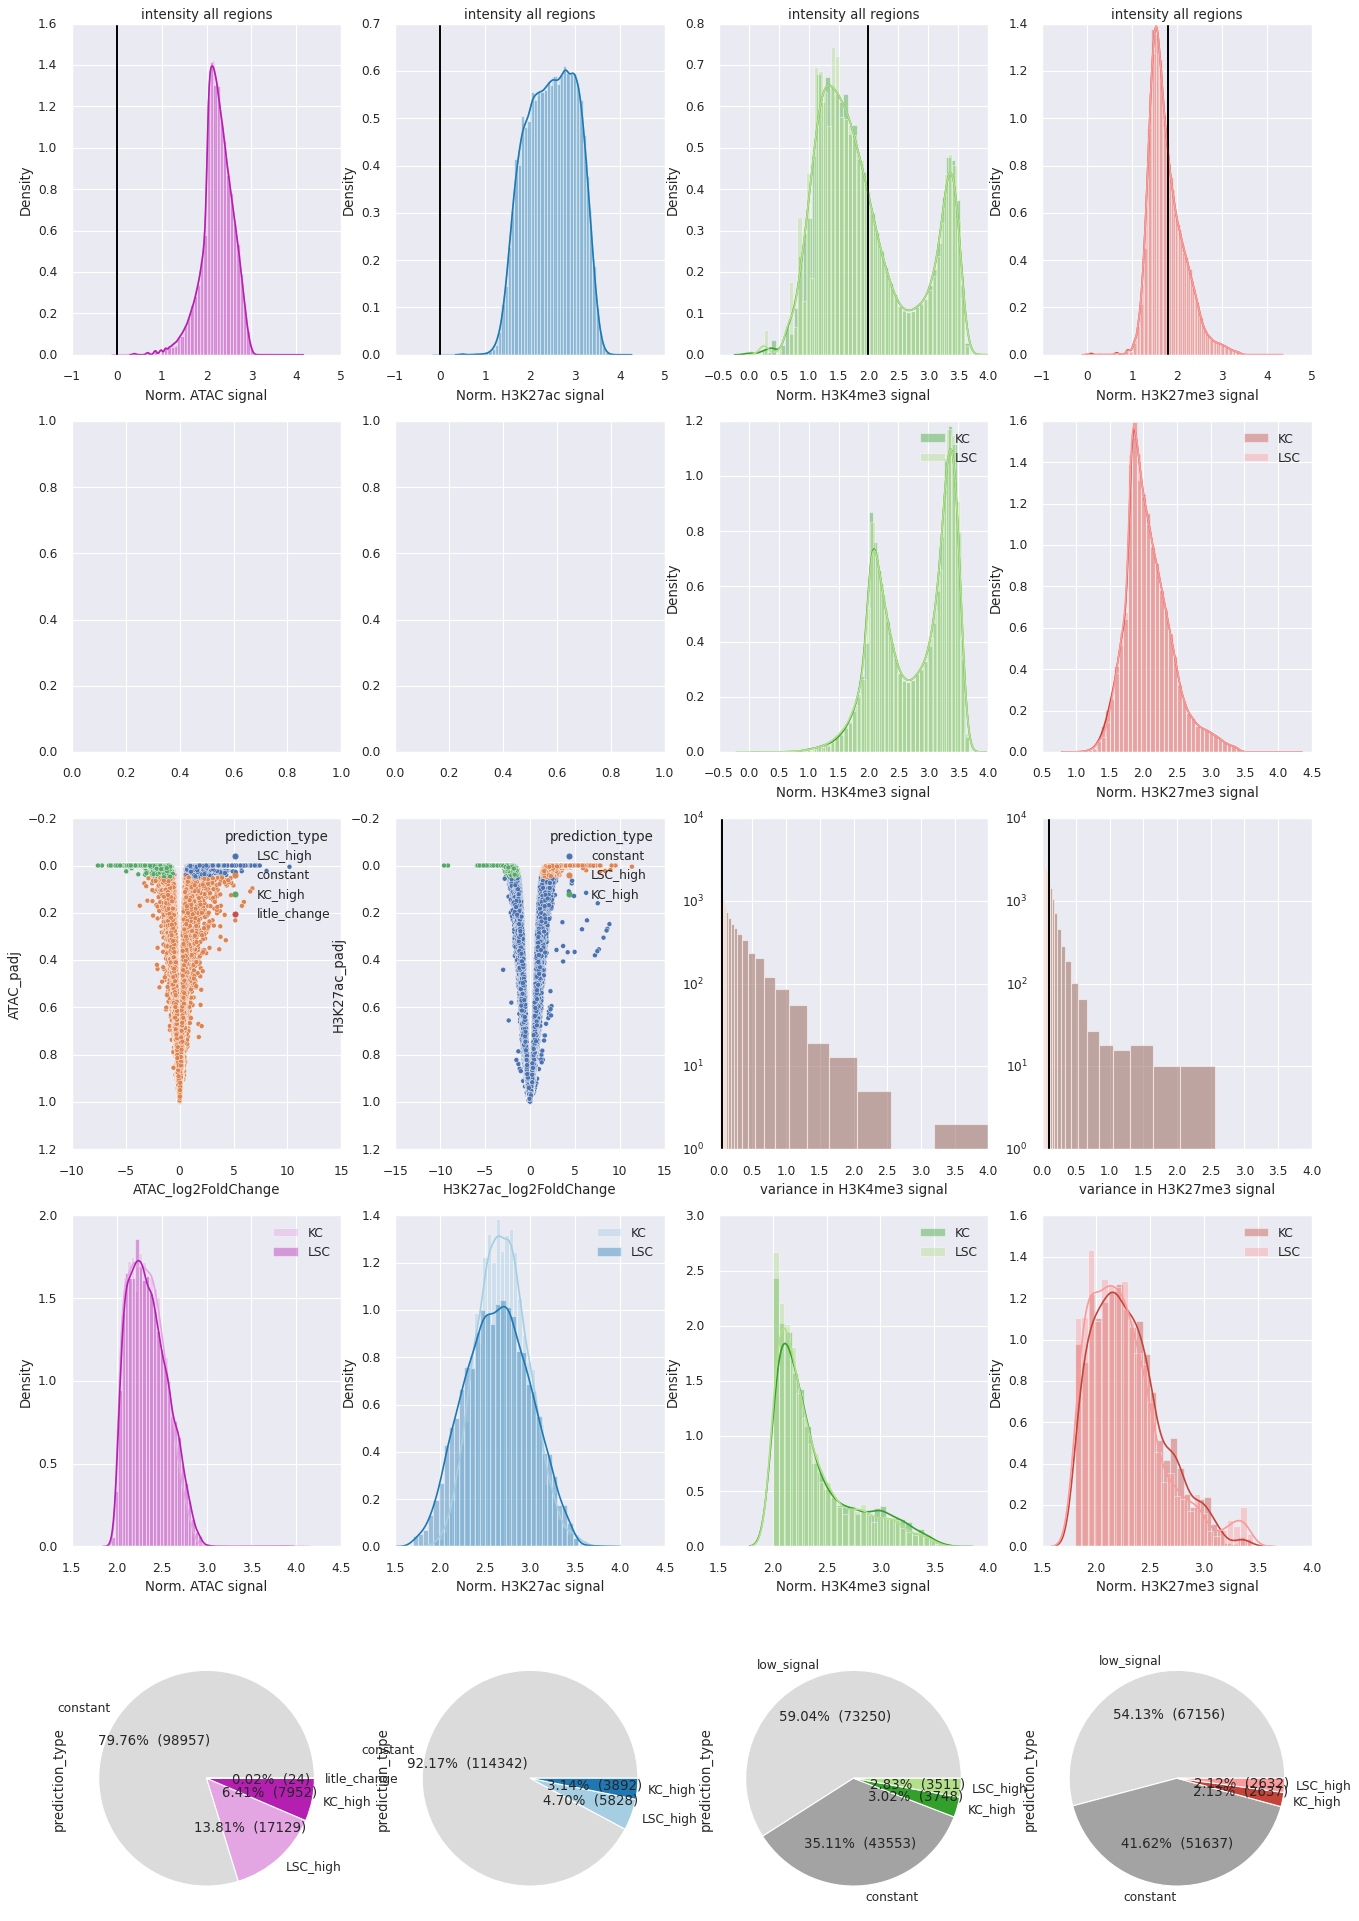

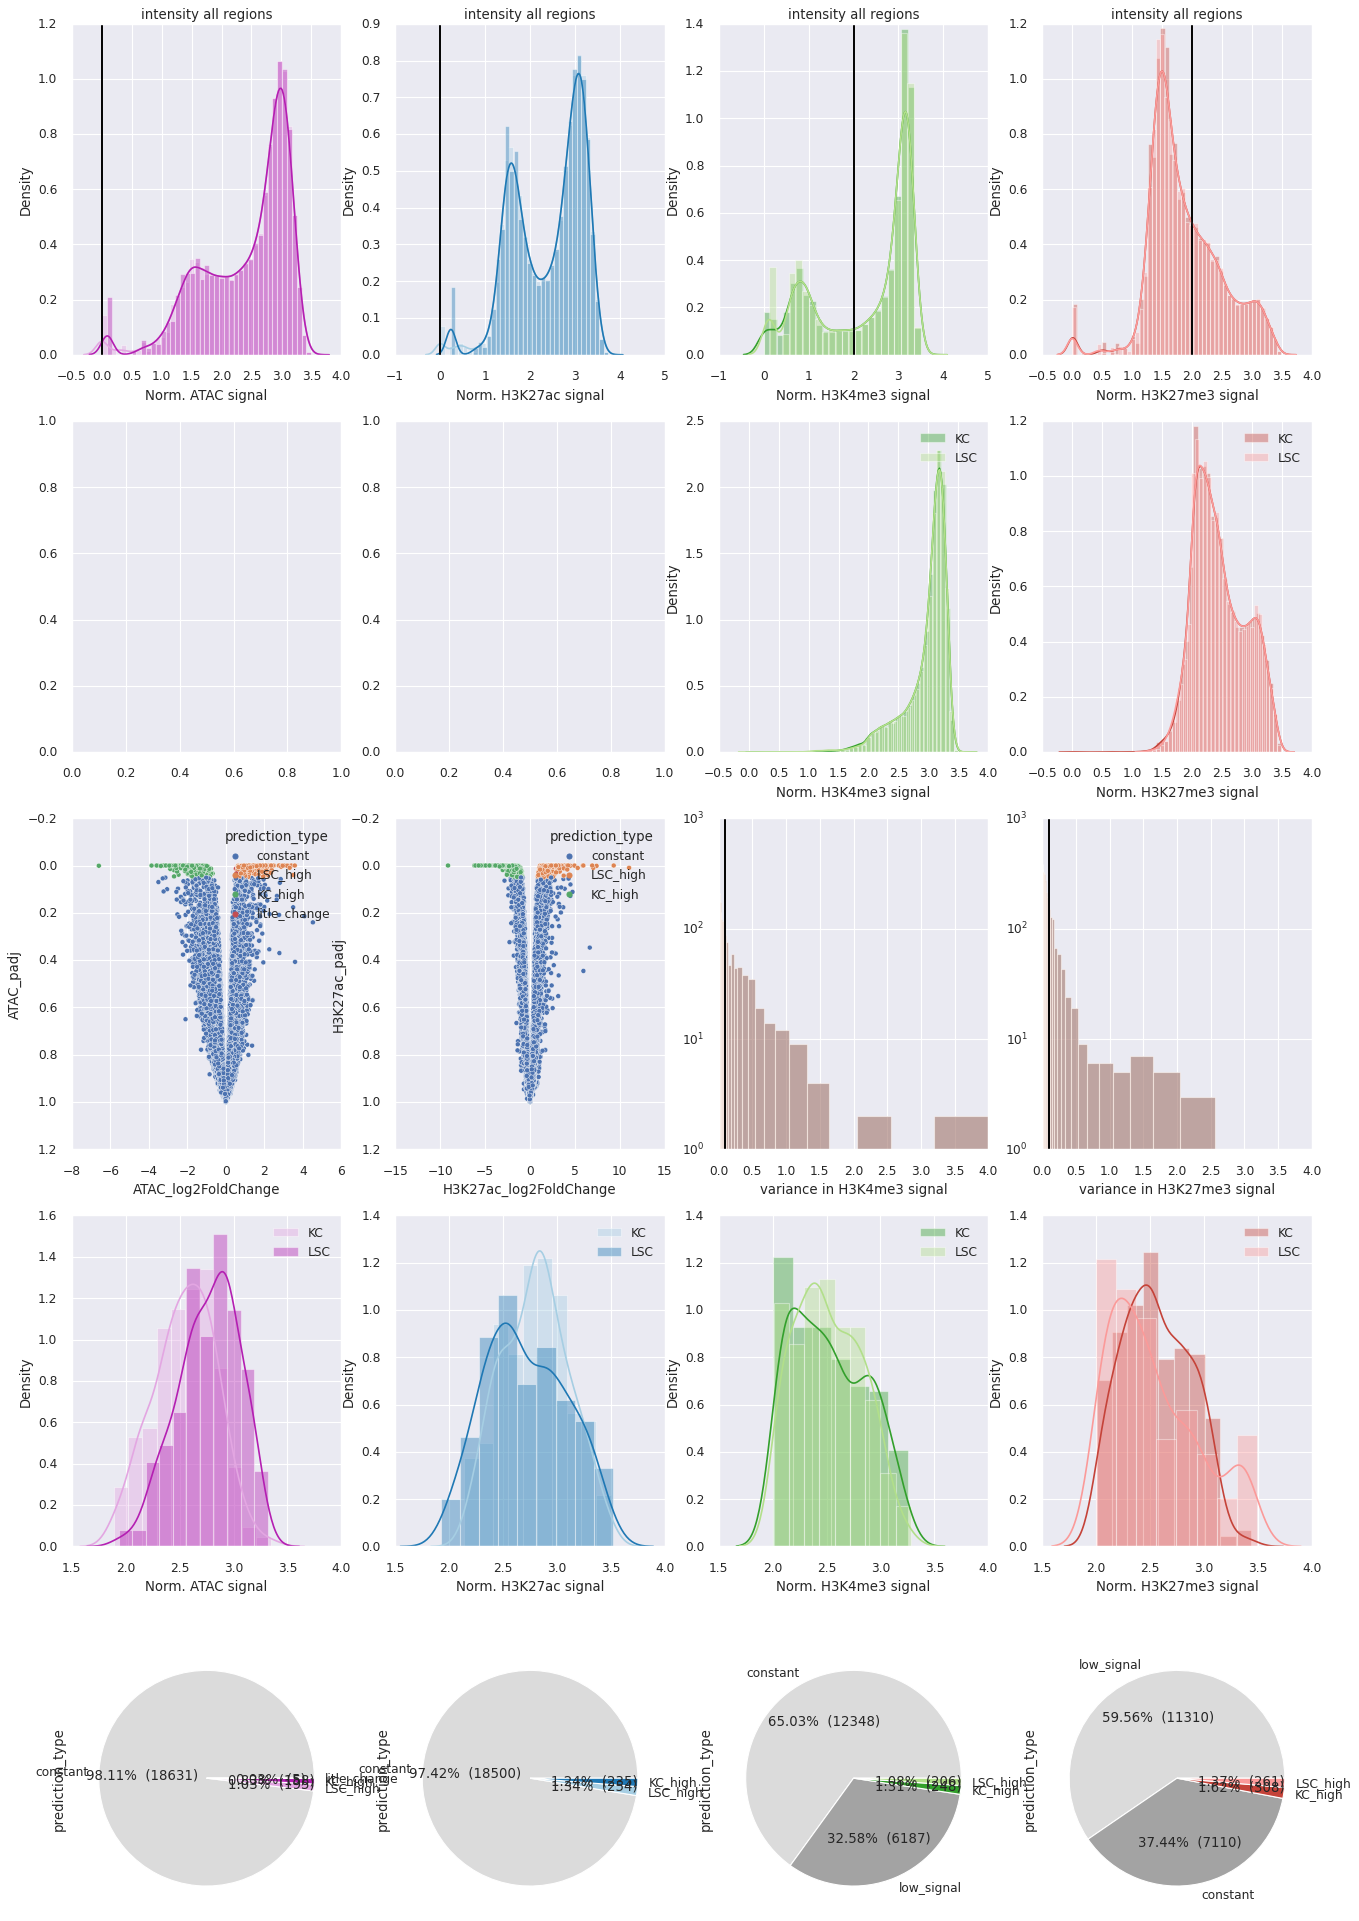

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
ID_CREs.SummitHistonesIntensities = {}
ID_CREs.TSSHistoneIntensities = {}
FC_cutoff = 0.58
pval_cutoff = 0.05

# for region_type, alter_window_size in zip(
for region_type, alter_window_size, activity_cutoffs, variance_cutoffs in zip(
    ["ATAC_summits", "TSS_regions"],
    [[200, 2000, 2000, 5000], [1000, 2000, 1000, 5000]],
    [[0, 0, 2, 1.8], [0, 0, 2.0, 2.0]],
    [[0, 0, 0.05, 0.1], [0, 0, 0.1, 0.1]],
):
    # plot all the cutoffs:
    plt.style.use("seaborn")
    sns.set(rc={"figure.figsize": (20, 30)})
    fig, axes = plt.subplots(5, 4)

    for (mark, window, y_ax, colgrey, col1, col2, cuttoff, var_cuttoff) in zip(
        ["ATAC", "H3K27ac", "H3K4me3", "H3K27me3"],
        alter_window_size,
        [0, 1, 2, 3],
        [["#dbdbdb"], ["#dbdbdb"], ["#dbdbdb", "#a3a3a3"], ["#dbdbdb", "#a3a3a3"]],
        ["#e3a6e2", "#A6CEE3", "#33A02C", "#C54339"],
        ["#b41fb2", "#1F78B4", "#B2DF8A", "#FB9A99"],
        activity_cutoffs,
        variance_cutoffs,
    ):
        output_file = f"{ID_CREs.tmpdir}/{region_type}_{mark}_{window}"

        histone_intensity_reads = pd.read_table(
            f"{ID_CREs.tmpdir}/{region_type}_{mark}_{window}_coverage.txt",
            sep="\t",
            index_col=False,
        )
        histone_intensity_reads["region"] = (
            histone_intensity_reads["Chrom"].astype(str)
            + ":"
            + histone_intensity_reads["ChromStart"].astype(str)
            + "-"
            + histone_intensity_reads["ChromEnd"].astype(str)
        )
        histone_intensity_reads = histone_intensity_reads.drop_duplicates(
            subset=["region"]
        )
        region_ids = histone_intensity_reads["region"]
        histone_intensity_reads = histone_intensity_reads.drop("region", axis=1)
        histone_intensity_reads = histone_intensity_reads.drop("Chrom", axis=1)
        histone_intensity_reads = histone_intensity_reads.drop("ChromStart", axis=1)
        histone_intensity_reads = histone_intensity_reads.drop("ChromEnd", axis=1)
        histone_intensity_reads.index = region_ids
        histone_intensity_reads.to_csv(
            f"{ID_CREs.tmpdir}/deseq2_counts.tsv",
            sep="\t",
            header=True,
            index=True,
        )
        histone_intensity_reads_agg = histone_intensity_reads.copy()

        for cell_type in ["KC", "LSC"]:
            columns_single_cell_type = list(
                ID_CREs.files[ID_CREs.files.data_type == f"{mark}_BAM"].cell_type
                == cell_type
            )
            histone_intensity_reads_agg[f"{cell_type}_counts_aggregated"] = (
                histone_intensity_reads.loc[:, columns_single_cell_type].sum(axis=1) + 1
            )

        histone_intensity_reads_agg[
            ["KC_qnorm", "LSC_qnorm"]
        ] = qnorm.quantile_normalize(
            np.log10(
                histone_intensity_reads_agg[
                    ["KC_counts_aggregated", "LSC_counts_aggregated"]
                ]
            )
        )

        histone_intensity_reads_agg["max_intensity"] = histone_intensity_reads_agg.loc[
            :, ["KC_qnorm", "LSC_qnorm"]
        ].max(axis=1)
        histone_intensity_reads_agg["variance"] = histone_intensity_reads_agg.loc[
            :, ["KC_qnorm", "LSC_qnorm"]
        ].var(axis=1)

        # vizualize the quantile based normalized intensity scores
        for cell_type, colour in zip(["LSC", "KC"], [col1, col2]):
            sns.distplot(
                histone_intensity_reads_agg[f"{cell_type}_qnorm"],
                hist=True,
                rug=False,
                label=cell_type,
                axlabel=("Norm. " + mark + " signal"),
                norm_hist=False,
                color=colour,
                ax=axes[0, int(y_ax)],
            ).set(title="intensity all regions")
            axes[0, int(y_ax)].axvline(cuttoff, 0, 1, color="black")

        # run deseq2 on H3K27ac and ATAC reads
        if mark in (["H3K27ac", "ATAC"]):
            if not os.path.exists(
                f"{ID_CREs.tmpdir}/diff_{region_type}_{mark}.csv"
            ):  # Run deseq2 to find regions with differential readcounts
                print(f"running deseq for mark {region_type} {mark}")
                sp.check_call(
                    f"Rscript --vanilla  "
                    f"{ID_CREs.main_dir}/RunDeseq2.R "
                    f"{ID_CREs.tmpdir}/deseq2_counts.tsv "
                    f"{ID_CREs.main_dir}/{mark}_sample_file.csv "
                    f"{ID_CREs.tmpdir}/deseq2_{region_type}_{mark}.tsv "
                    f"> {ID_CREs.logdir}/deseq2_{region_type}_{mark}.txt",
                    shell=True,
                )

                # load the deseq2 df, add to each columns an identifier which type of data it is.
                DESEQ2_res = pd.read_table(
                    f"{ID_CREs.tmpdir}/deseq2_{region_type}_{mark}.tsv",
                    sep=",",
                    index_col=False,
                )
                DESEQ2_res = DESEQ2_res.drop("Unnamed: 0", axis=1)
                DESEQ2_res.columns = [
                    mark + "_" + str(col) for col in DESEQ2_res.columns
                ]
                DESEQ2_res.to_csv(
                    f"{ID_CREs.tmpdir}/diff_{region_type}_{mark}.csv",
                    sep=",",
                    header=True,
                    index=False,
                )

            else:
                DESEQ2_res = pd.read_table(
                    f"{ID_CREs.tmpdir}/diff_{region_type}_{mark}.csv",
                    sep=",",
                    index_col=False,
                )
            # merge DESEQ
            histone_intensity_reads_agg = histone_intensity_reads_agg.merge(
                DESEQ2_res, left_index=True, right_on=f"{mark}_region"
            )
            df = histone_intensity_reads_agg
            print(f"get differential regions {mark} {region_type}")
            conditions = [
                (df.max_intensity < cuttoff),
                (df[f"{mark}_padj"] > pval_cutoff),
                (
                    (df[f"{mark}_padj"] <= pval_cutoff)
                    & (abs(df[f"{mark}_log2FoldChange"]) < FC_cutoff)
                ),
                (
                    (df[f"{mark}_padj"] <= pval_cutoff)
                    & (abs(df[f"{mark}_log2FoldChange"]) > FC_cutoff)
                    & (df.KC_qnorm > df.LSC_qnorm)
                ),
                (
                    (df[f"{mark}_padj"] <= pval_cutoff)
                    & (abs(df[f"{mark}_log2FoldChange"]) > FC_cutoff)
                    & (df.LSC_qnorm > df.KC_qnorm)
                ),
            ]
            choices = ["low_signal", "constant", "litle_change", "KC_high", "LSC_high"]
            df["prediction_type"] = np.select(conditions, choices, default="constant")
            df[["Chrom", "ChromStart", "ChromEnd"]] = df.loc[
                :, f"{mark}_region"
            ].str.split("[:-]", expand=True)
            df[["Chrom", "ChromStart", "ChromEnd"]] = df.loc[
                :, f"{mark}_region"
            ].str.split("[:-]", expand=True)

            # plot vulcano plot
            sns.scatterplot(
                data=df,
                x=f"{mark}_log2FoldChange",
                y=f"{mark}_padj",
                hue="prediction_type",
                ax=axes[2, int(y_ax)],
            )
            axes[2, int(y_ax)].invert_yaxis()

        if mark in (["H3K4me3", "H3K27me3"]):
            print(f"get highly variable regions {mark} {region_type}")
            df = histone_intensity_reads_agg
            conditions = [
                (df.max_intensity < cuttoff),
                ((df.max_intensity > cuttoff) & (df.variance < var_cuttoff)),
                (
                    (df.max_intensity > cuttoff)
                    & (df.variance >= var_cuttoff)
                    & (df.KC_qnorm > df.LSC_qnorm)
                ),
                (
                    (df.max_intensity > cuttoff)
                    & (df.variance >= var_cuttoff)
                    & (df.LSC_qnorm > df.KC_qnorm)
                ),
            ]
            choices = ["low_signal", "constant", "KC_high", "LSC_high"]
            df["prediction_type"] = np.select(conditions, choices, default=0)
            df["region"] = df.index
            df[["Chrom", "ChromStart", "ChromEnd"]] = df.loc[:, "region"].str.split(
                "[:-]", expand=True
            )
            # Plot active regions: distribution:
            for cell_type, colour in zip(["KC", "LSC"], [col1, col2]):
                sns.distplot(
                    df[df.max_intensity > cuttoff][[f"{cell_type}_qnorm"]],
                    hist=True,
                    rug=False,
                    label=cell_type,
                    axlabel=("Norm. " + mark + " signal"),
                    norm_hist=False,
                    color=colour,
                    ax=axes[1, int(y_ax)],
                )
                axes[1, int(y_ax)].legend()
                sns.distplot(
                    df[df.max_intensity > cuttoff][["variance"]],
                    label="LSC vs KC",
                    kde=False,
                    norm_hist=False,
                    axlabel="variance in " + mark + " signal",
                    ax=axes[2, int(y_ax)],
                    bins=np.logspace(np.log10(0.000000001), np.log10(4.0), 100),
                )
                axes[2, int(y_ax)].set_yscale("log")
                axes[2, int(y_ax)].axvline(var_cuttoff, color="black")

        # If a mark is bellow the activity cutoff value, we will remove the qnormalized intensity of that
        # region. That way we can make sure that when performing motif analysis, we are not looking at nothing/almost nothing
        # changes.
        df.loc[df["prediction_type"] == "low_signal", "KC_qnorm"] = 0
        df.loc[df["prediction_type"] == "low_signal", "LSC_qnorm"] = 0

        if region_type == "ATAC_summits":
            ID_CREs.SummitHistonesIntensities[(region_type + "_" + mark)] = df
        if region_type == "TSS_regions":
            ID_CREs.TSSHistoneIntensities[(region_type + "_" + mark)] = df

        # plot variable/differential distribution
        for cell_type, colour in zip(["KC", "LSC"], [col1, col2]):
            sns.distplot(
                df[df["prediction_type"].isin([f"{cell_type}_high"])][
                    [f"{cell_type}_qnorm"]
                ],
                hist=True,
                rug=False,
                label=cell_type,
                axlabel=("Norm. " + mark + " signal"),
                norm_hist=False,
                color=colour,
                ax=axes[3, int(y_ax)],
            )
            axes[3, int(y_ax)].legend()

        # plot ratio common/variable active regions:

        colour_list = colgrey.copy()
        colour_list.append(col1)
        colour_list.append(col2)
        df.prediction_type.value_counts().plot(
            kind="pie",
            autopct=make_autopct(df.prediction_type.value_counts()),
            subplots=True,
            figsize=(6, 6),
            colors=colour_list,
            ax=axes[4, int(y_ax)],
        )

    fig.savefig(f"{ID_CREs.figdir}/{region_type}_cutoffs.pdf")

### Merge the TSS histone modification info

In [43]:
for marktypes in ID_CREs.TSSHistoneIntensities:
    print(marktypes)
    df = ID_CREs.TSSHistoneIntensities.get(marktypes)
    # get back to TSS summit
    window_length = df.ChromEnd.astype(int) - df.ChromStart.astype(int)
    df.ChromEnd = (df.ChromEnd.astype(int) - window_length / 2).astype(int)
    df.ChromStart = (df.ChromStart.astype(int) + window_length / 2).astype(int)
    df["TSS"] = (
        df.Chrom.astype(str)
        + ":"
        + df.ChromStart.astype(str)
        + "-"
        + df.ChromEnd.astype(str)
    )
    ID_CREs.TSSHistoneIntensities[marktypes] = df
    df.to_csv(
        f"{ID_CREs.tmpdir}/{marktypes}.csv",
        sep=",",
        header=True,
        index=False,
    )

TSS_regions_ATAC
TSS_regions_H3K27ac
TSS_regions_H3K4me3
TSS_regions_H3K27me3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# merge into a single TSS object
df1 = ID_CREs.TSSHistoneIntensities.get("TSS_regions_H3K27ac").copy()
df1.columns = [str(col) + "_TSS_regions_H3K27ac" for col in df1.columns]
df2 = ID_CREs.TSSHistoneIntensities.get("TSS_regions_H3K4me3").copy()
df2.columns = [str(col) + "_TSS_regions_H3K4me3" for col in df2.columns]
df3 = ID_CREs.TSSHistoneIntensities.get("TSS_regions_ATAC").copy()
df3.columns = [str(col) + "_TSS_regions_ATAC" for col in df3.columns]
df4 = ID_CREs.TSSHistoneIntensities.get("TSS_regions_H3K27me3").copy()
df4.columns = [str(col) + "_TSS_regions_H3K27me3" for col in df4.columns]

df_all = df1.merge(
    df2,
    left_on="TSS_TSS_regions_H3K27ac",
    right_on="TSS_TSS_regions_H3K4me3",
    how="outer",
)
df_all = df_all.merge(
    df3, left_on="TSS_TSS_regions_H3K27ac", right_on="TSS_TSS_regions_ATAC", how="outer"
)
df_all = df_all.merge(
    df4,
    left_on="TSS_TSS_regions_H3K27ac",
    right_on="TSS_TSS_regions_H3K27me3",
    how="outer",
)
df_all.to_csv(
    f"{ID_CREs.tmpdir}/All_TSS_window_data.csv",
    sep=",",
    header=True,
    index=False,
)

# Link the TSS windows to the TSS regions
# Get the TSS from the GTF data:
gene_TSS = ID_CREs.TSS_1bp
window_length = gene_TSS.ChromEnd.astype(int) - gene_TSS.ChromStart.astype(int)
gene_TSS.ChromEnd = (gene_TSS.ChromEnd.astype(int) - window_length / 2).astype(int)
gene_TSS.ChromStart = (gene_TSS.ChromStart.astype(int) + window_length / 2).astype(int)
gene_TSS["TSS"] = (
    gene_TSS.Chrom.astype(str)
    + ":"
    + gene_TSS.ChromStart.astype(str)
    + "-"
    + gene_TSS.ChromEnd.astype(str)
)

df_all = df_all.merge(
    gene_TSS[["TSS", "gene", "strand"]],
    how="left",
    right_on="TSS",
    left_on="TSS_TSS_regions_H3K27me3",
)

df_TSS_all = df_all.copy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
# finally lets add the DESEQ2 info regarding the genes if they are differential within the RNAseq data analysis object\
df_transcriptome = pd.read_table(
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/deseq2/output_figures_deseq2/2021-07-13/LSC_KC/KCvsLSC/all_genes.csv",
    sep=";",
    index_col=0,
)
df_transcriptome.columns = [str(col) + "_RNAseq" for col in df_transcriptome.columns]
df_transcriptome
conditions = [
    # (df_transcriptome.BaseMean_RNAseq < 5.0),
    (
        (df_transcriptome.padj_RNAseq < 0.01)
        & (df_transcriptome.log2FoldChange_RNAseq < -0.58)
    ),
    (
        (df_transcriptome.padj_RNAseq < 0.01)
        & (df_transcriptome.log2FoldChange_RNAseq > 0.58)
    ),
]
choices = ["LSC_high", "KC_high"]
df_transcriptome["prediction_type_RNAseq"] = np.select(
    conditions, choices, default="constant"
)

df_all = df_all.merge(
    df_transcriptome,
    how="left",
    right_index=True,
    left_on="gene",
)

df_all.to_csv(
    f"{ID_CREs.tmpdir}/All_TSS_window_data_inc_RNAseq.csv",
    sep=",",
    header=True,
    index=False,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
annotation_df = df_all[
    [
        "gene",
        #
        "prediction_type_RNAseq",
        "prediction_type_TSS_regions_ATAC",
        "prediction_type_TSS_regions_H3K27ac",
        "prediction_type_TSS_regions_H3K4me3",
        "prediction_type_TSS_regions_H3K27me3",
        "prediction_type_TSS_regions_H3K27ac",
        #
        "log2FoldChange_RNAseq",
        "padj_RNAseq",
        #
        "LSC_qnorm_TSS_regions_H3K27ac",
        "KC_qnorm_TSS_regions_H3K27ac",
        "H3K27ac_log2FoldChange_TSS_regions_H3K27ac",
        "H3K27ac_padj_TSS_regions_H3K27ac",
        #
        "LSC_qnorm_TSS_regions_ATAC",
        "KC_qnorm_TSS_regions_ATAC",
        "ATAC_log2FoldChange_TSS_regions_ATAC",
        "ATAC_padj_TSS_regions_ATAC",
        #
        "LSC_qnorm_TSS_regions_H3K4me3",
        "KC_qnorm_TSS_regions_H3K4me3",
        "variance_TSS_regions_H3K4me3",
        #
        "LSC_qnorm_TSS_regions_H3K27me3",
        "KC_qnorm_TSS_regions_H3K27me3",
        "variance_TSS_regions_H3K27me3",
    ]
]

annotation_df.to_csv(
    f"{ID_CREs.output_dir}/TSS_regions_annotated.csv",
    sep=",",
    header=True,
    index=False,
)

annotation_df_TSS = annotation_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Link ATAC summits to the closest nearby genes

Next we will link the ATAC summits to the closest nearby genes, we will use 2 approaches.
1. We will map it to the closest gene and use this annotation for  H3K4me3, ATAC and H3K27me3 variable/diff regions.
2. We will map ATAC summits to all genes in a window. We will use this annotation for H3K27ac, which we will distance weigh.


In [47]:
TSS_bedfile = ID_CREs.TSS_1bp[["Chrom", "ChromStart", "ChromEnd", "strand", "gene"]]
TSS_bedfile["ChromEnd"] = TSS_bedfile["ChromEnd"] + 1
TSS_bedfile.to_csv(
    f"{ID_CREs.tmpdir}/TSS_regions.bed",
    sep="\t",
    header=False,
    index=False,
)

sp.check_call(
    f"bedSort {ID_CREs.tmpdir}/TSS_regions.bed {ID_CREs.tmpdir}/TSS_regions_sorted.bed ",
    shell=True,
)

0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Approach 1: all elements in TSS window (Motif enrichment)

In [51]:
# Lets first map all the ATAC summits to TSS regions within a window
sp.check_call(
    f"nice -14 bedtools window "
    f"-w 50000 "
    f"-a {ID_CREs.tmpdir}/TSS_regions.bed "
    f"-b {ID_CREs.output_dir}/accesible_summits.bed "
    f"> {ID_CREs.tmpdir}/tmp_bedtool_window.txt",
    shell=True,
)
pd_table = pd.read_table(
    f"{ID_CREs.tmpdir}/tmp_bedtool_window.txt",
    index_col=None,
    names=[
        "chr_TSS",
        "start_TSS",
        "end_TSS",
        "strand",
        "gene_name",
        "Chrom",
        "ChromStart",
        "ChromEnd",
    ],
)

distance = (
    []
)  # calculate the distance based on the TSS start end region start site, check which one is upstream for distance calc.
for x, y in zip(pd_table["start_TSS"], pd_table["ChromStart"]):
    if x > y:
        distance.append(x - y)
    elif y > x:
        distance.append(y - x)
    else:
        distance.append("NaN")

pd_table["distance"] = distance

TSS_2_ATAC_windows = pd_table[
    ["Chrom", "ChromStart", "ChromEnd", "gene_name", "distance"]
]
TSS_2_ATAC_windows["ChromStart"] = TSS_2_ATAC_windows["ChromStart"]
TSS_2_ATAC_windows["ChromEnd"] = TSS_2_ATAC_windows["ChromEnd"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
TSS_2_ATAC_windows["region"] = (
    TSS_2_ATAC_windows["Chrom"].astype(str)
    + ":"
    + TSS_2_ATAC_windows["ChromStart"].astype(str)
    + "-"
    + TSS_2_ATAC_windows["ChromEnd"].astype(str)
)
TSS_2_ATAC_windows.index = TSS_2_ATAC_windows["region"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Lets perform distance weight, H3K4me3,ATAC& H3K27me3 will be used counted when within 10kb distance of a TSS, while H3K27ac will use the ananse enhancer weight dict

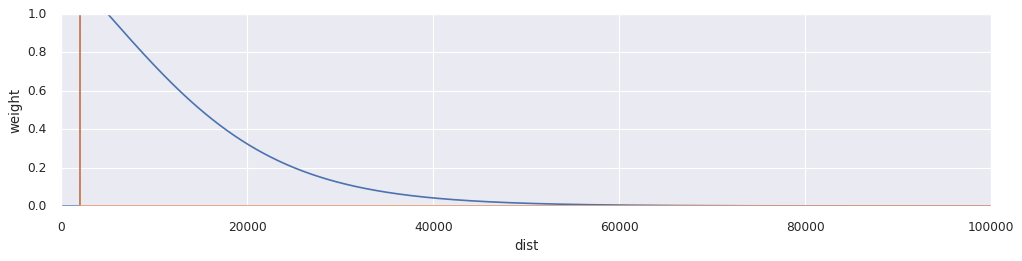

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
from Python_scripts import distance_weight
sns.set(rc={"figure.figsize": (15, 3)})
# import from Ananse
weight = distance_weight(alpha=1e4, include_promoter=False, include_enhancer = True)
sns.lineplot(x=weight["dist"], y=weight["weight"])
fig.savefig(f"{ID_CREs.figdir}/weight_distance_enhancer_window.pdf")
weight_dict = pd.Series(weight.weight.values, index=weight.dist).to_dict()
#H3K4me3 weigth dict
weight_H3K4me3 = distance_weight(alpha=1e4, include_promoter=True, include_enhancer=False)
mask = weight_H3K4me3.dist < 2000
column_name = "weight"
weight_H3K4me3.loc[mask, "weight"] = 1
sns.lineplot(x=weight_H3K4me3["dist"], y=weight_H3K4me3["weight"])
fig.savefig(f"{ID_CREs.figdir}/weight_distance_H3K4me3_window.pdf")
weight_H3K4me3_dict = pd.Series(weight_H3K4me3.weight.values, index=weight_H3K4me3.dist).to_dict()


In [57]:
ID_CREs.geneHistonesIntensities = {}

for histonemod, weight_dictionary in zip(
    ["H3K27me3", "ATAC", "H3K27ac", "H3K4me3"],
    [weight_H3K4me3_dict, weight_dict, weight_dict, weight_H3K4me3_dict],
):
    print(histonemod)
    marktypes = f"ATAC_summits_{histonemod}"
    print(f"{marktypes}")
    df = ID_CREs.SummitHistonesIntensities.get(marktypes)
    length = df["ChromEnd"].astype(int) - df["ChromStart"].astype(int)
    length = df["ChromEnd"].astype(int) - df["ChromStart"].astype(int)
    df["ChromStart_summit"] = (df["ChromStart"].astype(int) + (length - 1) / 2).astype(
        int
    ) - 100
    df["ChromEnd_summit"] = (df["ChromEnd"].astype(int) - (length - 1) / 2).astype(
        int
    ) + 99

    df["summit"] = (
        df["Chrom"].astype(str)
        + ":"
        + df["ChromStart_summit"].astype(str)
        + "-"
        + df["ChromEnd_summit"].astype(str)
    )
    if marktypes == "ATAC_summits_ATAC":
        df["summit"] = df["ATAC_region"]
        df["region"] = df["ATAC_region"]

    df = df.merge(
        TSS_2_ATAC_windows[["gene_name", "distance"]],
        right_index=True,
        left_on="summit",
        how="left",
    )

    # drop regions further than 50kb away
    df = df.dropna()
    df = df[df["distance"] != "NaN"]
    df["distance"].astype(int)
    df.sort_values(by="distance", axis=0)
    df = df[df["distance"] < 50000]

    print(f"perform distance weighing {histonemod}")
    df["weight"] = df["distance"].map(weight_dict)
    df[[f"KC_{histonemod}_weigthed", f"LSC_{histonemod}_weigthed",]] = (
        df[
            [
                "KC_qnorm",
                "LSC_qnorm",
            ]
        ]
        .astype(float)
        .multiply(df["weight"], axis="index")
    )

    # concatinate all enhancers (with a weight above 0.01) into a single distance sorted string for the output csv file
    # sort based on the distance of the enhancers per gene (for easier lookup in the excel file)
    #     df = df.groupby(["gene_name"], sort=False).apply(
    #         lambda x: x.sort_values(["distance"])
    #     )
    # df = df.drop("gene_name", axis=1)
    df = df.reset_index(drop=True)

    df[["distance"]] = df[["distance"]].astype(str)
    df[["LSC_qnorm"]] = df[["LSC_qnorm"]].astype(str)
    df[["KC_qnorm"]] = df[["KC_qnorm"]].astype(str)

    # # make a column containing all the enhancers for the output csv file
    df[f"{histonemod}_windows"] = (
        df[["gene_name", "summit"]]
        .groupby(["gene_name"])["summit"]
        .transform(lambda x: ",".join(x))
    )
    # # make a column containing all the enhancers distances the output csv file
    df[f"{histonemod}_window_distances"] = (
        df[["gene_name", "distance"]]
        .groupby(["gene_name"])["distance"]
        .transform(lambda x: ",".join(x))
    )
    # make a column containing all the enhancers there individual weighed intensity for within the output csv file
    df[f"{histonemod}_window_LSC_qnorm"] = (
        df[["gene_name", "LSC_qnorm"]]
        .groupby(["gene_name"])["LSC_qnorm"]
        .transform(lambda x: ",".join(x))
    )
    df[f"{histonemod}_window_KC_qnorm"] = (
        df[["gene_name", "KC_qnorm"]]
        .groupby(["gene_name"])["KC_qnorm"]
        .transform(lambda x: ",".join(x))
    )

    if histonemod == "H3K27me3" or histonemod == "H3K4me3":
        # aggregate multiple H3K27ac CRE's mapped to the same TSS region

        df = df[
            [
                "gene_name",
                f"max_intensity",
                f"{histonemod}_windows",
                f"{histonemod}_window_distances",
                f"{histonemod}_window_KC_qnorm",
                f"{histonemod}_window_LSC_qnorm",
                f"KC_{histonemod}_weigthed",
                f"LSC_{histonemod}_weigthed",
                f"variance",
            ]
        ]

        weighted_CRE_2_TSS = (
            df.groupby(
                [
                    "gene_name",
                    f"{histonemod}_windows",
                    f"{histonemod}_window_distances",
                    f"{histonemod}_window_KC_qnorm",
                    f"{histonemod}_window_LSC_qnorm",
                ]
            )
            .agg(
                {
                    "max_intensity": ["mean"],
                    "variance": ["mean"],
                    f"KC_{histonemod}_weigthed": ["sum"],
                    f"LSC_{histonemod}_weigthed": ["sum"],
                }
            )
            .reset_index()
        )

    else:
        df = df[
            [
                "gene_name",
                f"{histonemod}_log2FoldChange",
                f"{histonemod}_windows",
                f"{histonemod}_window_distances",
                f"{histonemod}_window_KC_qnorm",
                f"{histonemod}_window_LSC_qnorm",
                f"KC_{histonemod}_weigthed",
                f"LSC_{histonemod}_weigthed",
            ]
        ]

        weighted_CRE_2_TSS = (
            df.groupby(
                [
                    "gene_name",
                    f"{histonemod}_windows",
                    f"{histonemod}_window_distances",
                    f"{histonemod}_window_KC_qnorm",
                    f"{histonemod}_window_LSC_qnorm",
                ]
            )
            .agg(
                {
                    f"{histonemod}_log2FoldChange": ["mean"],
                    f"KC_{histonemod}_weigthed": ["sum"],
                    f"LSC_{histonemod}_weigthed": ["sum"],
                }
            )
            .reset_index()
        )
    weighted_CRE_2_TSS = weighted_CRE_2_TSS.dropna()
    weighted_CRE_2_TSS.columns = weighted_CRE_2_TSS.columns.droplevel(1)
    print(f"reweighted {histonemod} values")
    ID_CREs.geneHistonesIntensities[marktypes] = weighted_CRE_2_TSS

H3K27me3
ATAC_summits_H3K27me3
perform distance weighing H3K27me3
reweighted H3K27me3 values
ATAC
ATAC_summits_ATAC
perform distance weighing ATAC
reweighted ATAC values
H3K27ac
ATAC_summits_H3K27ac
perform distance weighing H3K27ac
reweighted H3K27ac values
H3K4me3
ATAC_summits_H3K4me3
perform distance weighing H3K4me3
reweighted H3K4me3 values


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# merge into a single summit object
df1 = ID_CREs.geneHistonesIntensities.get("ATAC_summits_H3K27ac").copy()
df2 = ID_CREs.geneHistonesIntensities.get("ATAC_summits_H3K4me3").copy()
df3 = ID_CREs.geneHistonesIntensities.get("ATAC_summits_ATAC").copy()
df4 = ID_CREs.geneHistonesIntensities.get("ATAC_summits_H3K27me3").copy()

df1.columns = [str(col) + "_H3K27ac" for col in df1.columns]
df2.columns = [str(col) + "_H3K4me3" for col in df2.columns]
df3.columns = [str(col) + "_ATAC" for col in df3.columns]
df4.columns = [str(col) + "_H3K27me3" for col in df4.columns]

df_all = df1.merge(
    df2,
    left_on="gene_name_H3K27ac",
    right_on="gene_name_H3K4me3",
    how="outer",
)
df_all["gene_name"] = df_all["gene_name_H3K27ac"]
df_all.loc[df_all["gene_name"].isnull(), "gene_name"] = df_all["gene_name_H3K4me3"]
df_all = df_all.merge(
    df3,
    left_on="gene_name",
    right_on="gene_name_ATAC",
    how="outer",
)
df_all.loc[df_all["gene_name"].isnull(), "gene_name"] = df_all["gene_name_ATAC"]

df_all = df_all.merge(
    df4,
    left_on="gene_name",
    right_on="gene_name_H3K27me3",
    how="outer",
)
df_all.loc[df_all["gene_name"].isnull(), "gene_name"] = df_all["gene_name_H3K27me3"]
# df_all["gene_name"] = df_all["gene_name"].str.replace('"', "").values
# df_all["gene_name"] = df_all["gene_name"].str.replace(" ", "").values

# Finally lets also add the RNAseq expression data
df_all = df_all.merge(
    df_transcriptome,
    left_on="gene_name",
    right_index=True,
    how="outer",
)
# df_all.loc[df_all["gene_name"].isnull(), "gene_name"] = df_all["gene_name_H3K27me3"]
df_all.index = df_all["gene_name"]

df_all.to_csv(
    f"{ID_CREs.output_dir}/All_summit_window_data.csv",
    sep=",",
    header=True,
    index=True,
)
df_all.to_csv(
    f"{ID_CREs.tmpdir}/All_summit_window_data.csv",
    sep=",",
    header=True,
    index=True,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
df_all

NameError: name 'df_all' is not defined

### Approach 2: link CRE to closest TSS region

In [59]:
# Lets first map all the ATAC summits to the closest TSS regions
sp.check_call(
    f"nice -14 bedtools closest "
    f"-b {ID_CREs.tmpdir}/TSS_regions_sorted.bed "
    f"-a {ID_CREs.output_dir}/accesible_summits.bed "
    f"-d "
    f"> {ID_CREs.tmpdir}/tmp_bedtool_closest.txt",
    shell=True,
)
# gather all the CRE info,
df1 = ID_CREs.SummitHistonesIntensities.get("ATAC_summits_H3K27ac").copy()[
    [
        "Chrom",
        "ChromStart_summit",
        "ChromEnd_summit",
        "KC_qnorm",
        "LSC_qnorm",
        "prediction_type",
    ]
]
df2 = ID_CREs.SummitHistonesIntensities.get("ATAC_summits_H3K4me3").copy()[
    ["KC_qnorm", "LSC_qnorm", "prediction_type"]
]
df3 = ID_CREs.SummitHistonesIntensities.get("ATAC_summits_ATAC").copy()[
    ["KC_qnorm", "LSC_qnorm", "prediction_type"]
]
df4 = ID_CREs.SummitHistonesIntensities.get("ATAC_summits_H3K27me3").copy()[
    ["KC_qnorm", "LSC_qnorm", "prediction_type"]
]

df_all = pd.concat(
    [
        df1.reset_index(drop=True),
        df2.reset_index(drop=True),
        df3.reset_index(drop=True),
        df4.reset_index(drop=True),
    ],
    axis=1,
)
# df_all.index = df2.index
df_all.columns = [
    "Chrom",
    "ChromStart",
    "ChromEnd",
    "KC_qnorm_ATAC",
    "LSC_qnorm_ATAC",
    "Annotation_ATAC",
    "KC_qnorm_H3K27ac",
    "LSC_qnorm_H3K27ac",
    "Annotation_H3K27ac",
    "KC_qnorm_H3K4me3",
    "LSC_qnorm_H3K4me3",
    "Annotation_H3Kme3",
    "KC_qnorm_H3K27me3",
    "LSC_qnorm_H3K27me3",
    "Annotation_H3K27me3",
]
df_all["ChromEnd"] = df_all["ChromEnd"] + 1

df_all.index = (
    df_all["Chrom"].astype(str)
    + ":"
    + df_all["ChromStart"].astype(str)
    + "-"
    + df_all["ChromEnd"].astype(str)
)

# merge the CRE annotation together with the closest gene info
closest_gene = pd.read_table(
    f"{ID_CREs.tmpdir}/tmp_bedtool_closest.txt",
    index_col=None,
    names=[
        "chr_CRE",
        "start_CRE",
        "end_CRE",
        "chr_gene",
        "start_gene",
        "end_gene",
        "strand_gene",
        "gene",
        "dist",
    ],
)
closest_gene.end_CRE = closest_gene.end_CRE + 1
closest_gene.index = (
    closest_gene.chr_CRE.astype(str)
    + ":"
    + closest_gene.start_CRE.astype(str)
    + "-"
    + closest_gene.end_CRE.astype(str)
)

gene_linked_peaks = closest_gene[["gene", "dist"]].merge(
    df_all, left_index=True, right_index=True, how="outer"
)
gene_linked_peaks = gene_linked_peaks[gene_linked_peaks["dist"] < 20000]


# lets also link expression changes to to df
gene_linked_peaks = gene_linked_peaks.merge(
    df_transcriptome,
    how="left",
    right_index=True,
    left_on="gene",
)

# output to table to run GO-enrichment & generate pretty heatmap in R
gene_linked_peaks.to_csv(
    f"{ID_CREs.output_dir}/annotated_peaks.csv",
    sep=",",
    header=True,
    index=True,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Vizualize variable/differential regions

### Get a BED file with all variable TSS regions and variable ATAC seq regions
Finally, lest vizualize the differential/variable regions using fluff

In [ ]:
def merge_bw_replicas(input_bw, genome_path_size, output_bw):
    """
    input_bw: list of bw replica's to merge
    genome_path_size: file of chrom sizes of a genome
    ouput_bw: location of the output bw file
    """
    input_bw = " ".join(input_bw)
    print("merging to bedgraph")
    sp.check_call(
        f"bigWigMerge {input_bw} {output_bw}.tmp",
        shell=True,
    )
    print("sorting bedgraph")
    sp.check_call(
        f"bedSort {output_bw}.tmp {output_bw}.bedgraph",
        shell=True,
    )
    print(" bedgraph 2 bw")
    sp.check_call(
        f"bedGraphToBigWig {output_bw}.bedgraph {genome_path_size} {output_bw} ",
        shell=True,
    )
    print("removing bedgraph")
    sp.check_call(f"rm -r {output_bw}.tmp", shell=True)
    sp.check_call(f"rm -r {output_bw}.bedgraph", shell=True)

In [ ]:
ID_CREs.files = pd.read_table(
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/files.tsv",
    sep="\t",
    comment="#",
    index_col=0,
    header=0,
)

ID_CREs.files

In [ ]:
samples_for_Fluff = ID_CREs.files.file_location.filter(regex=".bam|.BAM")
all_bamfiles = ID_CREs.files[ID_CREs.files.index.isin(samples_for_Fluff.index)]
genome_path_size = (
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes"
)

merged_samples_dict = {}
merged_samples_list = list()
merged_samples_list_LSCs = list()
merged_samples_color = list()
merged_samples_ID = list()

# lets merge replica's to vizualize only one track per data type
for data_type in all_bamfiles["data_type"].unique():
    data_type_subset = all_bamfiles[all_bamfiles["data_type"] == data_type]
    #print(data_type)
    datatype_list = list()
    
    
    for cell_type in all_bamfiles["cell_type"].unique():
        #print(cell_type)
        data_and_cell_subset = data_type_subset[
            data_type_subset["cell_type"] == cell_type
        ]
        merged_samples_color.append(data_and_cell_subset.color[0])
        merged_samples_ID.append(
            data_and_cell_subset["cell_type"][0]
            + " "
            + data_and_cell_subset["data_type"][0][:-4]
        )
        if len(data_and_cell_subset) == 1:
            merged_samples_dict[f'{cell_type}_{data_type}'] = data_and_cell_subset.file_location[0]
            datatype_list.append(data_and_cell_subset.bw_location[0])
            merged_samples_list.append(data_and_cell_subset.file_location[0]) 

        if len(data_and_cell_subset) > 1:
            print("merging replica bigwig files")
            bam_list = list(data_and_cell_subset.file_location)
            print(cell_type)
            print(f"{' '.join(list(data_and_cell_subset.bw_location))} ")
            if not os.path.exists(
                f"{ID_CREs.tmpdir}/{data_type}_{cell_type}_merged.bigWig"
            ):
                merge_bw_replicas(list(data_and_cell_subset.bw_location), genome_path_size, f"{ID_CREs.tmpdir}/{data_type}_{cell_type}_merged.bigWig")

            datatype_list.append(f"{ID_CREs.tmpdir}/{data_type}_{cell_type}_merged.bigWig")
            merged_samples_list.append(f"{ID_CREs.tmpdir}/{data_type}_{cell_type}_merged.bigWig") 
            merged_samples_dict[data_type] = datatype_list
for file in merged_samples_list:
    print(file)


In [ ]:
all_colours = (
    "'#6A3D9A','#6A3D9A','#1F78B4','#1F78B4','#33A02C','#33A02C','#C54339','#C54339'"
)

gene_linked_peaks[["Chrom", "ChromStart", "ChromEnd"]].to_csv(
    f"{ID_CREs.tmpdir}/CREs_linked_to_TSS.bed",
    sep="\t",
    header=False,
    index=False,
)
sp.check_call(
    f"fluff heatmap "
    f"-f {ID_CREs.tmpdir}/CREs_linked_to_TSS.bed "
    f"-d {' '.join(merged_samples_list)}  "
    f"-o {ID_CREs.figdir}/fluff_all_regions "
    f"-c {all_colours} "
    f"-e 5000 "
    f"-C k -k 12 -m "
    f"-P 12 "
    f"-r ",
    shell=True,
)

In [ ]:
# lets next vizualize only the variable regions
var_gene_linked_peaks = gene_linked_peaks[
    gene_linked_peaks[
        [
            "Annotation_ATAC",
            "Annotation_H3K27ac",
            "Annotation_H3K27me3",
            "Annotation_H3Kme3",
        ]
    ]
    .isin(["LSC_high", "KC_high"])
    .any(axis=1)
]
var_gene_linked_peaks[["Chrom", "ChromStart", "ChromEnd"]].to_csv(
    f"{ID_CREs.tmpdir}/varCREs_linked_to_TSS.bed",
    sep="\t",
    header=False,
    index=False,
)

sp.check_call(
    f"fluff heatmap "
    f"-f {ID_CREs.tmpdir}/varCREs_linked_to_TSS.bed "
    f"-d {' '.join(merged_samples_list)}  "
    f"-o {ID_CREs.figdir}/fluff_var_regions "
    f"-c {all_colours} "
    f"-e 5000 "
    f"-C k -k 12 -m "
    f"-P 12 "
    f"-r ",
    shell=True,
)

## TNFa target gene TSS regions

Lets finally vizualizet he TSS regions/ATAC summits linked to TNFa target genes.

We will load the progeny table to extract which genes are targeted by TNFa.

In [ ]:
# load the progeny matrix:
progeny_coef = pd.read_table(
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/tools/progeny_coef.csv",
    sep=",",
    comment="#",
    index_col=0,
    header=0,
)
TNF_target_genes = progeny_coef[(progeny_coef[["TNFa"]] > 0).TNFa]
TNF_target_genes = TNF_target_genes.sort_values(by='TNFa', ascending = False)
#TNF_target_genes = list(TNF_target_genes.index.values)

# extract the TSS regions of the TNFa target genes
TSS_regions = pd.read_table(
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/ID_CREs/2021-28-07/TSS_1bp.bed",
    sep="\t",
    names=["Chrom", "ChromStart", "ChromEnd", "Strand", "gene"],
)

# get the TSS regions of TNF targets
TNF_target_TSS = TSS_regions.merge(TNF_target_genes, left_on = 'gene', right_index = True)
#elongate to a window of 
TNF_target_TSS = TNF_target_TSS.sort_values(by='TNFa', ascending = False)

TNF_target_TSS[['ChromStart']] = TNF_target_TSS[['ChromStart']] - 2500
TNF_target_TSS[['ChromEnd']] = TNF_target_TSS[['ChromEnd']] + 2500


TNF_target_TSS[["Chrom", "ChromStart", "ChromEnd"]].to_csv(
    f"{ID_CREs.tmpdir}/TNFA_target_TSS.bed",
    sep="\t",
    header=False,
    index=False,
)

print('running fluff heatmap')
sp.check_call(
    f"fluff heatmap "
    f"-f {ID_CREs.tmpdir}/TNFA_target_TSS.bed "
    f"-d {' '.join(merged_samples_list)}  "
    f"-o {ID_CREs.figdir}/fluff_TNFA_targets "
    f"-c {all_colours} "
    f'-e 5000 '
    f"-P 12 ",
    #f'-C k -k 5 -r',
    shell=True,
)
print('running fluff bandplot')
sp.check_call(
    f"fluff bandplot "
    f"-f {ID_CREs.figdir}/fluff_TNFA_targets_clusters.bed "
    f"-d {' '.join(merged_samples_list)}  "
    f"-o {ID_CREs.figdir}/fluff_TNFA_targets_bandplot "
    f"-c {all_colours} "
    f"-P 12",
    shell=True,
)


In [ ]:
sp.check_call(
    f"fluff bandplot "
    f"-f {ID_CREs.figdir}/fluff_TNFA_targets_clusters.bed "
    f"-d {' '.join(merged_samples_list)}  "
    f"-o {ID_CREs.figdir}/fluff_TNFA_targets_bandplot "
    f"-c {all_colours} "
    f"-P 12 "
    f'-r ',
    shell=True,
)


In [ ]:
TNF_target_TSS = TSS_regions[(TSS_regions[["Gene"]].isin(TNF_target_genes)).Gene]

### WIP Vizualize all the (variable) CRE's on the genome browser

In [ ]:
for regions in ["Promoters", "Accesible_regions"]:
    for mark, common_col, LSC_col, KC_col in zip(
        ["ATAC", "H3K27ac", "H3K4me3", "H3K27me3"],
        ["230,230,250", "75,172,198", "155,187,89", "250,191,143"],
        ["186,85,211", "166,206,227", "178,223,138", "251,154,153"],
        ["148,0,211", "31,120,180", "51,160,44", "197,67,57"],
    ):

        viz_data = region_dataframes[regions][
            [
                f"{mark}_region",
                f"{mark}_annotation",
            ]
        ]
        viz_data[["Chrom", "ChromStart", "ChromEnd"]] = viz_data[
            f"{mark}_region"
        ].str.split("[:-]", expand=True)
        viz_data.loc[:, "score"] = 0
        viz_data.loc[:, "strand"] = "."

        viz_data[viz_data[f"{mark}_annotation"] != f"low_{mark}"]

        # We will highlight the subarea of each region on which motif enrichment is performed downstream. To do this
        # we will take an area of 200bp in the exact center of each region and use those coordinates for the column
        # thickStart and thickEnd

        if regions == "Accesible_regions":
            region_length = viz_data["ChromEnd"].astype(int) - viz_data[
                "ChromStart"
            ].astype(int)
            summit = viz_data["ChromStart"].astype(int) + region_length / 2
            viz_data["thickStart"] = (
                summit - (int(settings.summit_length[1]) / 2)
            ).astype(int)
            viz_data["thickEnd"] = (
                summit + (int(settings.summit_length[1]) / 2)
            ).astype(int)
        else:
            viz_data["thickStart"] = viz_data["ChromStart"]
            viz_data["thickEnd"] = viz_data["ChromEnd"]

        rgbdict = {
            # "common_H3K27ac": "75,172,198",
            f"{mark}_constant": common_col,
            f"{mark}_LSC_high": LSC_col,
            f"{mark}_KC_high": KC_col,
            f"low_{mark}": "194,194,214",
        }

        viz_data["reserved"] = viz_data[f"{mark}_annotation"].map(rgbdict)

        viz_data[
            [
                f"Chrom",
                f"ChromStart",
                f"ChromEnd",
                f"{mark}_annotation",
                f"score",
                f"strand",
                f"thickStart",
                f"thickEnd",
                f"reserved",
            ]
        ].to_csv(
            f"{trackhub_dir}/{regions}_{mark}.bed", sep="\t", header=False, index=False
        )

        # sort the bedfile:
        sp.check_call(
            f"nice -5 bedSort "
            f"{trackhub_dir}/{regions}_{mark}.bed "
            f"{trackhub_dir}/{regions}_{mark}_sorted.bed"
            f"2> {log_dir}/bedToBigBed_{regions}_{mark}_regions.log",
            shell=True,
        )

        # convert the bedfile to a bigbed file
        sp.check_call(
            f"nice -5 bedToBigBed "
            f"-type=bed9 "
            f"{trackhub_dir}/{regions}_{mark}_sorted.bed "
            f"{files.genome_path_size[1]} "
            f"{trackhub_dir}/{regions}_{mark}_regions.bigBed "
            f"2> {log_dir}/bedToBigBed_{regions}_{mark}_regions.log",
            shell=True,
        )

        sp.check_call(
            f"nice -5 cp "
            f"{trackhub_dir}/{regions}_{mark}_regions.bigBed "
            f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/web-share/RNA_seq/hg38/{regions}_{mark}_regions.bigBed ",
            shell=True,
        )